<a href="https://colab.research.google.com/github/luckedenn/loanCorrelation/blob/main/rakamin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from google.colab import drive
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, precision_recall_curve

In [10]:
# Load dataset
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/loan_data_2007_2014.csv'
loan_data = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-10-57dbf8984ae0>:4: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  loan_data = pd.read_csv(file_path)


In [35]:
loan_data.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
loan_data.shape

(466285, 75)

In [36]:
# Step 1: Clean dataset by removing columns with all missing values
loan_data_cleaned = loan_data.dropna(axis=1, how='all')

In [37]:
loan_data_cleaned.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,NaN,Sep-13,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,NaN,Jan-15,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN


In [42]:
loan_data_cleaned.shape

(466285, 58)

In [38]:
# Step 2: Select relevant columns for analysis
relevant_columns = ['loan_amnt', 'term', 'int_rate', 'grade', 'loan_status']
loan_data_subset = loan_data_cleaned[relevant_columns]

In [39]:
# Step 3: Encode categorical columns (e.g., 'term', 'grade', 'loan_status')
loan_data_subset['term'] = loan_data_subset['term'].str.extract('(\d+)').astype(int)  # Extract numeric term
loan_data_subset['grade'] = loan_data_subset['grade'].astype('category').cat.codes  # Encode grades
loan_data_subset['loan_status'] = loan_data_subset['loan_status'].apply(
    lambda x: 1 if x.lower() == 'fully paid' else 0)  # Binary encode loan status

<ipython-input-39-9e9535237294>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_subset['term'] = loan_data_subset['term'].str.extract('(\d+)').astype(int)  # Extract numeric term
<ipython-input-39-9e9535237294>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_subset['grade'] = loan_data_subset['grade'].astype('category').cat.codes  # Encode grades
<ipython-input-39-9e9535237294>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [44]:
# Step 3: Handle missing values (optional: fill with median/mode if critical features have NaNs)
loan_data_subset.fillna(method='ffill', inplace=True)  # Forward fill as an example

<ipython-input-44-510f628b535d>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  loan_data_subset.fillna(method='ffill', inplace=True)  # Forward fill as an example
<ipython-input-44-510f628b535d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_subset.fillna(method='ffill', inplace=True)  # Forward fill as an example


In [45]:
scaler = StandardScaler()
loan_data_subset[['loan_amnt', 'int_rate']] = scaler.fit_transform(loan_data_subset[['loan_amnt', 'int_rate']])

<ipython-input-45-975097a8c593>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_subset[['loan_amnt', 'int_rate']] = scaler.fit_transform(loan_data_subset[['loan_amnt', 'int_rate']])


In [57]:
loan_data_subset.head()

,loan_amnt,term,int_rate,grade,loan_status
0,-1.124392,36,-0.729587,1,1
1,-1.426088,60,0.330634,2,0
2,-1.438156,36,0.488979,2,1
3,-0.521001,36,-0.077850,2,1
4,-1.365749,60,-0.261438,1,0


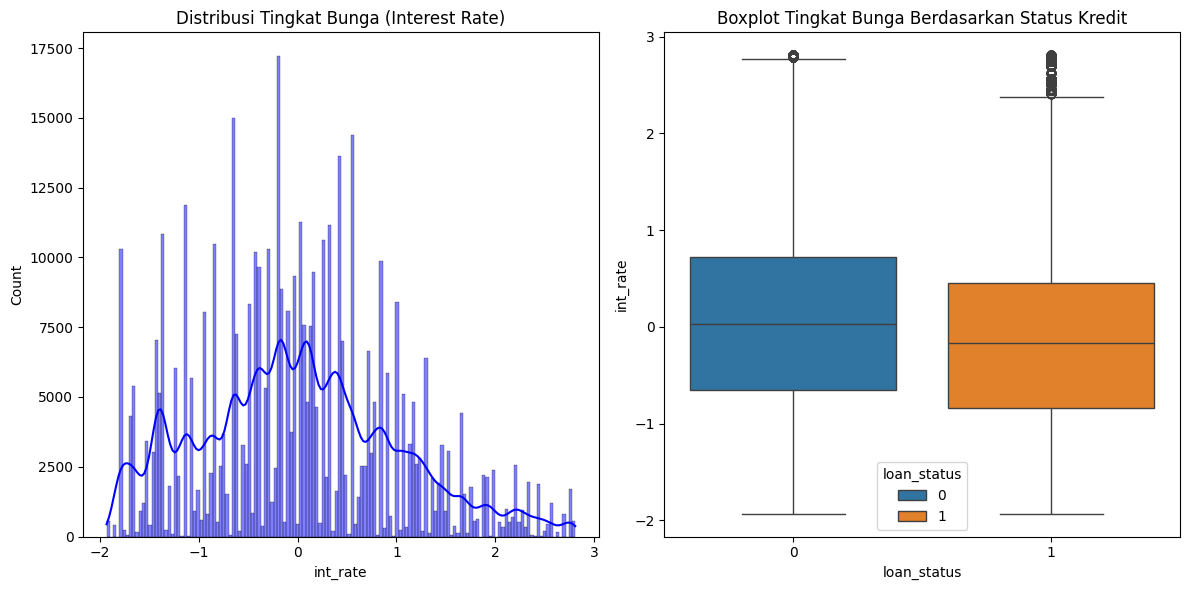

In [56]:
# 1. Histogram dan Boxplot untuk distribusi data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(loan_data_subset['int_rate'], kde=True, color='blue')
plt.title('Distribusi Tingkat Bunga (Interest Rate)')

plt.subplot(1, 2, 2)
sns.boxplot(x='loan_status', y='int_rate', data=loan_data_subset, hue='loan_status', dodge=False)
plt.title('Boxplot Tingkat Bunga Berdasarkan Status Kredit')
plt.tight_layout()
plt.show()

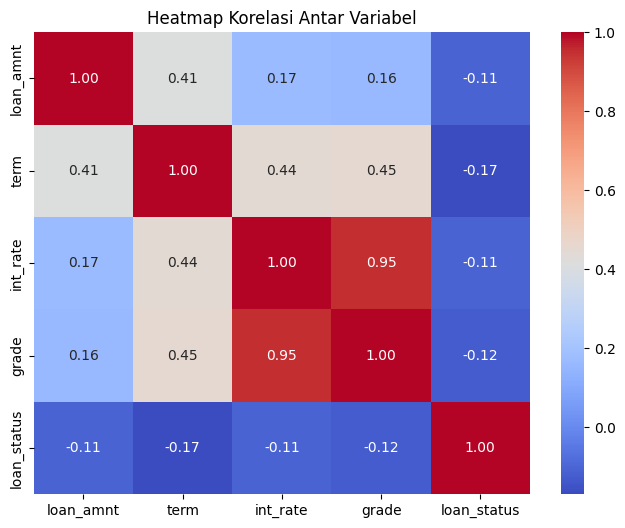

In [55]:
# 2. Heatmap Korelasi antar variabel
plt.figure(figsize=(8, 6))
correlation = loan_data_subset.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap Korelasi Antar Variabel')
plt.show()

In [47]:
# Step 4: Split data into training and testing sets
X = loan_data_subset.drop(columns=['loan_status'])
y = loan_data_subset['loan_status']

# Handle class imbalance using SMOTE (optional)
smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_resample(X, y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [48]:
# Step 5: Train Logistic Regression model
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [49]:
# Train Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [50]:
# Step 6: Evaluate models
# Logistic Regression
y_pred_logreg = logreg.predict(X_test)
logreg_report = classification_report(y_test, y_pred_logreg)
logreg_roc_auc = roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])

In [51]:
# Random Forest
y_pred_rf = rf.predict(X_test)
rf_report = classification_report(y_test, y_pred_rf)
rf_roc_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])

In [52]:
# Print evaluation results
print("Logistic Regression Classification Report:")
print(logreg_report)
print(f"Logistic Regression ROC-AUC Score: {logreg_roc_auc}\n")

print("Random Forest Classification Report:")
print(rf_report)
print(f"Random Forest ROC-AUC Score: {rf_roc_auc}")

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.96      0.75     56351
           1       0.56      0.08      0.14     36906

    accuracy                           0.61     93257
   macro avg       0.59      0.52      0.45     93257
weighted avg       0.59      0.61      0.51     93257

Logistic Regression ROC-AUC Score: 0.6161580479797719

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.80      0.75     56351
           1       0.61      0.48      0.54     36906

    accuracy                           0.67     93257
   macro avg       0.66      0.64      0.64     93257
weighted avg       0.66      0.67      0.66     93257

Random Forest ROC-AUC Score: 0.6862797829880037


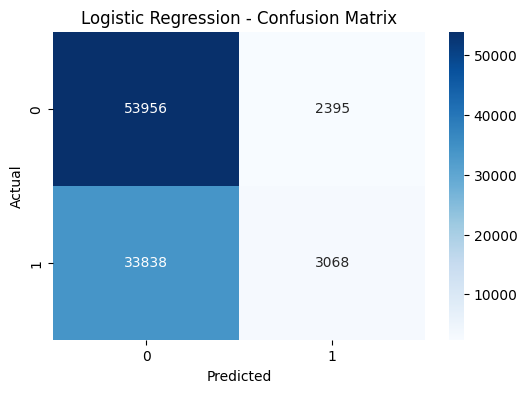

In [53]:
# Visualize Confusion Matrix for Logistic Regression
plt.figure(figsize=(6, 4))
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)
sns.heatmap(conf_matrix_logreg, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

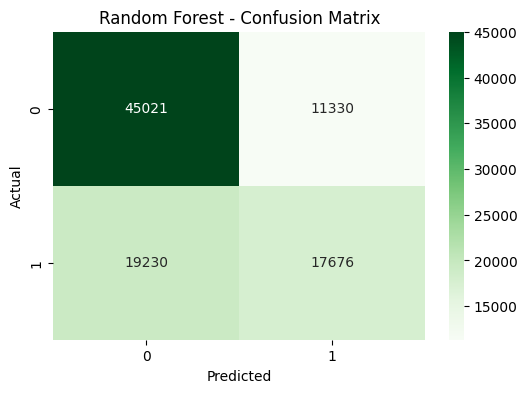

In [54]:
# Visualize Confusion Matrix for Random Forest
plt.figure(figsize=(6, 4))
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Greens')
plt.title('Random Forest - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()